In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
import networkx as nx
import seaborn as sns

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

from CD_methods import SCM_learner

from tqdm import tqdm

Code plan:
- Input: Spike data, node information, stimulation information
- To do: Learn SCM
- Output: Learned graph

### Testing function here

In [16]:
n_obs = 20
n_hidden = 20

index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

n_networks = 1

# model parameters
theta = 3
mu = 0
sigma = 5

generator = NormalGenerator(
    n_neurons=n_obs + n_hidden,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=1,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

network_data = generator.generate(n_networks)
example_network = network_data[0]
G = to_networkx(example_network)

example_network.W0[example_network.W0 > 0.0] = 1.5
example_network.W0[example_network.W0 < 0.0] = -3

print(example_network.W0.shape)
print(example_network.edge_index.shape)
print(example_network.num_nodes)

torch.Size([779])
torch.Size([2, 779])
40


# Notes:
- Observed can have more variable synaptic weights
- plot ISI, mål CV (skal helst være bred), noise correlations -- to check if spike distr. is realistic

In [17]:
print(sum(example_network.W0 > 0))
print(sum(example_network.W0 < 0))
print(G.number_of_edges(), (390+389) // 2, )

tensor(390)
tensor(389)
779 389


In [18]:
# create small world network

# G = nx.erdos_renyi_graph(n = n_obs+n_hidden, p = 0.05, directed=True)
# n_edges = G.number_of_edges()
# dataset = from_networkx(G)
# dataset['W0'] = torch.zeros(n_edges)
# n_inhibitory = n_edges // 2
# n_excitatory = n_edges - n_inhibitory

# dataset.W0[:n_excitatory] = 1.5
# dataset.W0[n_excitatory:] = -3
# example_network = dataset

# print(example_network.W0.shape)
# print(example_network.edge_index.shape)
# print(example_network.num_nodes)
#W0 = torch.tensor([6.0, 7.5, 2.2, 1.4])

#dataset = Data(num_nodes=4, W0=W0, edge_index=edge_index)

#print(A_sw)

In [19]:
#example_network = torch.load('data/c_elegans_data.pt')
#print(example_network)
#n_neurons = example_network.num_nodes
#n_obs = 50
#n_hidden = n_neurons - n_obs
#index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

#G = to_networkx(example_network, node_attrs = ['position'])
#print(example_network.position)
#print(nx.get_node_attributes(G, 'position'))
#position_dict = nx.get_node_attributes(G, 'position')
#index_obs=[]
#for neuron in position_dict:
#    if position_dict[neuron] < 0.15:
#        index_obs.append(neuron)
#print(len(index_obs))


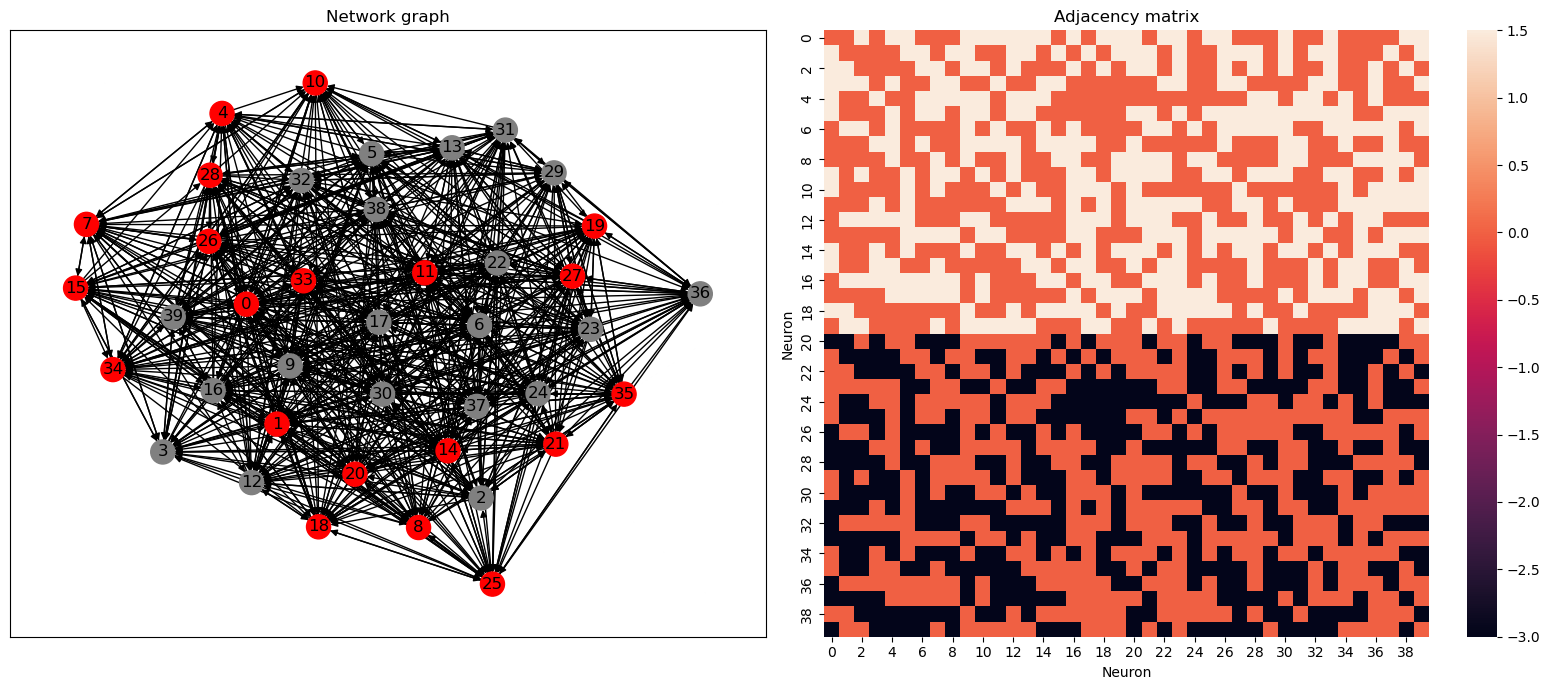

In [20]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=color_map)
ax[0].set_title("Network graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=False)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [21]:
int(n_obs*0.7)

14

In [22]:
prop_intervened = 1.0

spike_data = []
spike_data_dict = dict()
n_timesteps = 10**4

# complete single neuron stimulation protocol
stimulation_protocol = [[i] for i in index_obs]
stimulation_protocol_str = [str(i) for i in index_obs] + ['null']

stimulate_nodes = np.sort(np.random.choice(index_obs, size = int(n_obs*prop_intervened), replace = False))
stimulation_protocol = [[i] for i in stimulate_nodes]
stimulation_protocol_str = [str(i) for i in stimulate_nodes] + ['null']

print('Observed nodes', index_obs)
print(len(index_obs))
#print('stimulation_protocol_str', stimulation_protocol_str)

Observed nodes [ 0  1  4  7  8 10 11 14 15 18 19 20 21 25 26 27 28 33 34 35]
20


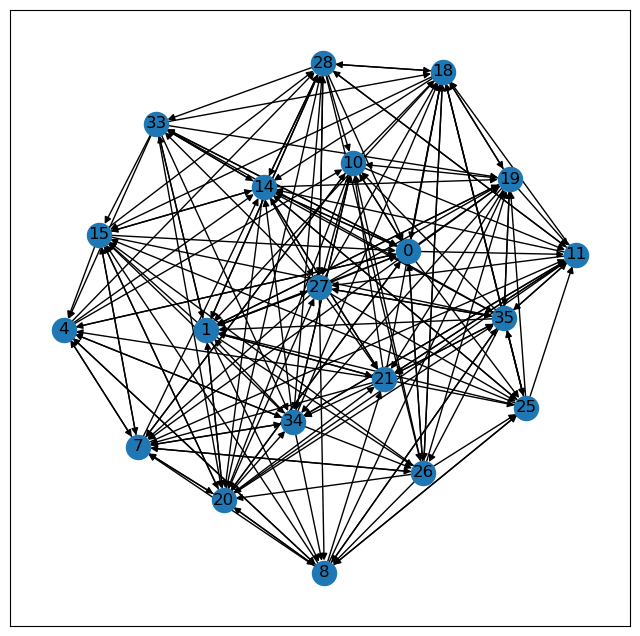

In [23]:
G_obs = nx.subgraph(G, index_obs)
plt.figure(figsize=(8,8))
nx.draw_networkx(G_obs, arrows=True)

In [24]:
for i, intervention in tqdm(enumerate(stimulation_protocol_str), total = len(stimulation_protocol_str)):

    # stimulate the observable neurons one by one
    stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
    
    if intervention != 'null':
        intervention_set = stimulation_protocol[i]
        stimulus_mask[intervention_set] = True
    
    #print('Simulating intervention on set ', intervention)
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data_dict[intervention] = spikes[index_obs]

100%|███████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


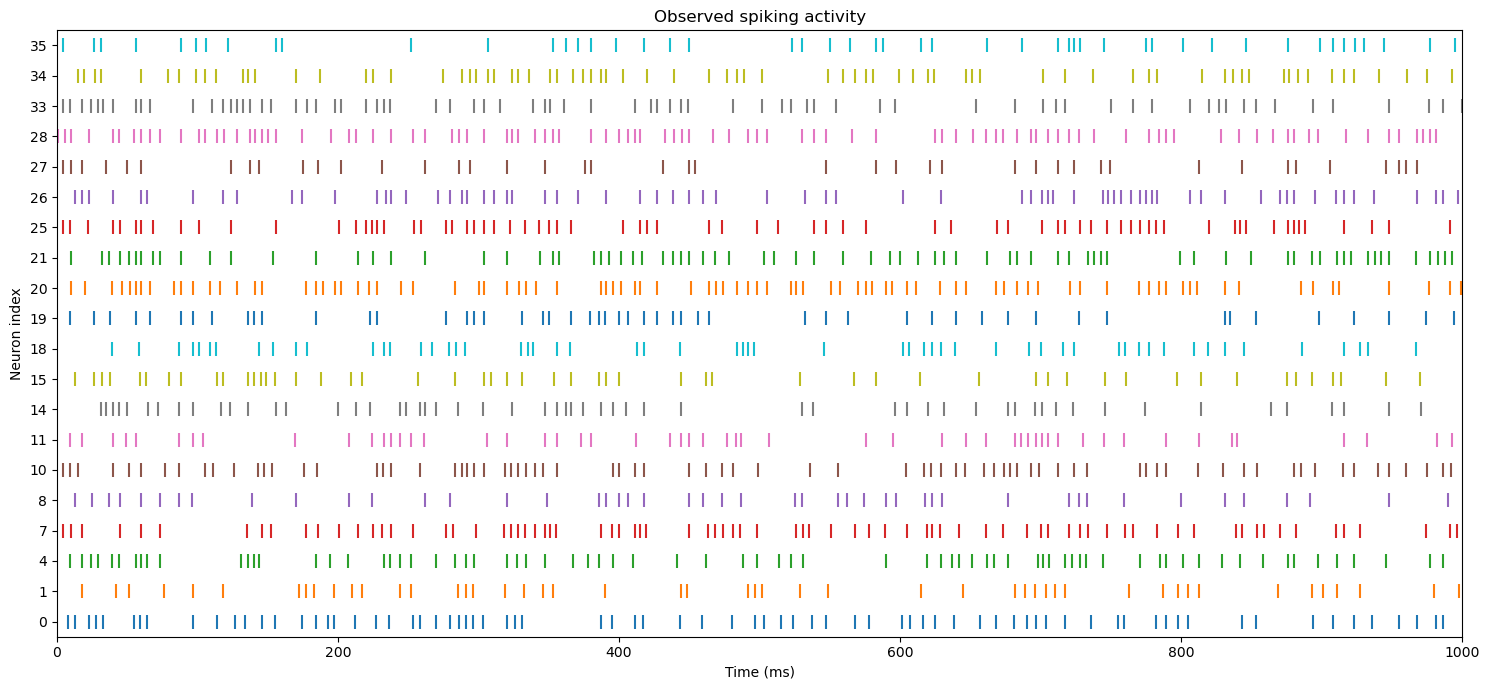

In [25]:
spikes = spike_data_dict['null']

plt.figure(figsize=(15,7))

for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [28]:
G_learned = SCM_learner_simplified(spike_data_dict, node_list=list(index_obs), stimulation_protocol=stimulation_protocol, alpha = 0.05)

In [29]:
G_true = nx.subgraph(G, index_obs)

"""
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

nx.draw_networkx(G_true, arrows=True, ax=ax[0])
ax[0].set_title("True graph")

nx.draw_networkx(G_learned, arrows=True, ax=ax[1])
ax[1].set_title("Learned graph")

plt.tight_layout()
plt.show()
"""

A_true = nx.adjacency_matrix(G_true).todense() 
A_learned = nx.adjacency_matrix(G_learned).todense() 
A_diff = A_true - A_learned

pd.DataFrame(A_true - A_learned)
SHD = np.sum(np.abs(A_true- A_learned))
print('SHD = ', SHD)

#print(G_true.edges())
#print(G_learned.edges())

print('True positives = ', np.sum( (A_true == 1)*(A_learned==1) ) )
print('True negatives = ', np.sum( (A_true == 0)*(A_learned==0)) )
print('False positives = ', np.sum(A_diff == -1) )
print('False negatives = ', np.sum(A_diff == 1) )

SHD =  5
True positives =  179
True negatives =  216
False positives =  5
False negatives =  0


### Notes
- For a network of 40 neurons, where 20 are observed, stimulating a randomly selected proportion of the observed nodes yields 
    - SHD(0%) = 15,
    - SHD(50%) = 10, 
    - SHD(60%) = 9,
    - SHD(70%) = 5,
    - SHD(80%) = 1,
    - SHD(100%) = 2.

What I an be explored further:
- Compare SHD of several networks (different connectivities, same num. observed and hidden nodes), where I vary the proportion of how many (single) nodes in the network are stimulated, too see how many singleton interventions are needed to correct for confounding effects.
- Look at multiple intervention protocols as well.
- Compare different algorithms and count number of needed interventions / intervention sets.

In [595]:
import pickle

results = {
    'spike_data' : spike_data_dict, 
    'G_true' : G, 
    'G_learned' : G_learned, 
    'nodes_observed' : index_obs,
    'stimulation_protocol' : stimulation_protocol
}

with open(f'data/results_{n_obs}_{n_hidden}_nodes.pickle','wb') as f:
        pickle.dump(results,f)  

In [540]:
10**4 / 10**3

10.0

In [43]:
def SCM_learner(spike_data, node_list, stimulation_protocol, alpha=0.01):
    """
    spike_data: dictionary of observed neuron data sets, where the key is the intervention used. 'null' is no intervetion. 
    '1' means node 1 was intervened on, '123' means node 1, 2 and 3 were intervened on, etc.
    node_list: a list contining node names of the observed variables
    stimulation_protocol: list of indeces for intervened neurons at each intervention.
    """
    SCM_learned = nx.DiGraph()
    SCM_learned.add_nodes_from(np.sort(node_list))

    # observational data
    spikes = spike_data['null']
    
    #stimulation_protocol_str = [''.join(str(i) for i in intervention_set) for intervention_set in stimulation_protocol]
        
    # loop through nodes in network, to test what other notes can explain spiking using a linear model
    for idx, neuron_id in enumerate(node_list):
        
        target_spikes = spikes[idx].numpy()
        
        source_spikes = np.delete(torch.roll(spikes, 1), idx, axis=0) # effect from 1 time step before
        #source_spikes2 = np.delete(torch.roll(spikes, 2), idx, axis=0) # effect from 2 time step before
        autoregressive_feature1 = torch.roll(spikes[idx], 1).numpy() # 1 time step history effects
        autoregressive_feature2 = torch.roll(spikes[idx], 2).numpy() # 2 time step history effects
        autoregressive_feature3 = torch.roll(spikes[idx], 3).numpy() # 3 time step history effects

        # create design matrix
        X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

        # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
        linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
        res = linear_model.fit()

        source_nodes = np.delete(node_list, idx) # remove target neuron
        p_values = res.pvalues[1:len(node_list)] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
        
        #print(p_values)
        
        for k, p in enumerate(p_values):
            if p < alpha:
                SCM_learned.add_edge(source_nodes[k], neuron_id)
    
    # Adjacency matrix based on observational data
    A_learned = nx.adjacency_matrix(SCM_learned).todense() 
    SCM_observational = SCM_learned.copy()

    # loop through each intervention set to remove confounding effects
    for intervention_set in stimulation_protocol:
        intervention_set_str = ''.join(str(x) for x in intervention_set)        
        spikes = spike_data[intervention_set_str] # get data set where the given intervention occurred

        for intervened_neuron in intervention_set:            
            intervened_neuron_idx = node_list.index(intervened_neuron)

            # get indeces of neurons that intervened node is correlated with
            target_idx = np.where(A_learned[intervened_neuron_idx, :] == 1) 
            #target_neurons = node_list[target_idx[0]]
            target_neurons = [v for _, v in SCM_observational.out_edges(intervened_neuron)]

            if len(target_neurons) == 0:
                continue

            else:
                # loop through the neurons that the intervened node is observationally correlated with
                for target_neuron in target_neurons:
                    target_neuron_idx = node_list.index(target_neuron)

                    sources_idx = np.where(A_learned[:, target_neuron_idx] == 1) # possible explanations for target neuron
                    #source_neurons = index_obs[sources_idx[0]]
                    source_neurons = [u for u, _ in SCM_observational.in_edges(target_neuron)]

                    intervened_idx = np.where(source_neurons == intervened_neuron)[0]
                    target_spikes = spikes[target_neuron_idx].numpy()

                    source_spikes = torch.roll(spikes[sources_idx[0]], 1).numpy() # effect from 1 time step before
                    #source_spikes2 = torch.roll(spikes[sources_idx[0]], 2).numpy() # effect from 2 time step before
                    autoregressive_feature1 = torch.roll(spikes[target_neuron_idx], 1).numpy() # 1 time step history effects
                    autoregressive_feature2 = torch.roll(spikes[target_neuron_idx], 2).numpy() # 2 time step history effects

                    # create design matrix
                    X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

                    # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
                    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
                    res = linear_model.fit()
                    #print(res.pvalues)
                    p_values = res.pvalues[intervened_idx+1] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
                    #
                    #print('p_values = ',p_values)
                    #print(res.pvalues)
                    if np.any(p_values > alpha):
                        #print(f'removed edge ({intervened_neuron}, {target_neuron})')
                        SCM_learned.remove_edge(intervened_neuron, target_neuron)

    return SCM_learned